First of all: importing needed modules

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

2024-05-29 08:27:25.308359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 08:27:26.181260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Step 2: Loading the Dataset
(downloaded from Kaggle 'Real Doppler RAD-DAR database')

In [2]:
DIR = './Project4-data/data'
CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(DIR):
    tmp = root.strip().split('/')
    if tmp[-2] in CLASS:
        files.sort()
        temp_imgs = []
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root,file), sep=',',header=None)
                temp_imgs.append(df.values)
        
        # process the 3-step-samples
        for id in range(0, len(temp_imgs)-2):
            list_of_img.append(np.stack([temp_imgs[id], temp_imgs[id+1], temp_imgs[id+2]], axis=-1))
            list_of_classi.append(CLASS[tmp[-2]])

x = np.array(list_of_img)
y = np.array(list_of_classi)

# changing y to one-hot encoding
y = keras.utils.to_categorical(y, num_classes=3)

The 3 test sample was chosen because the reference paper highlights the importance of the time-stability analysis to correctly classify the data. Furthermore, by loading the data in that shape we may use it, later on, on our implementation of the proposed model.

(17325, 11, 61, 3)
(17325, 3)


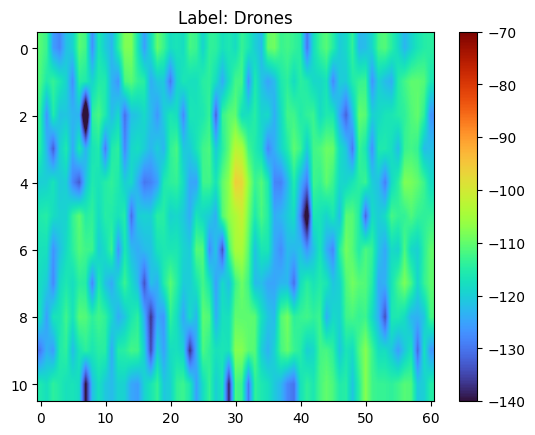

[5666. 5023. 6636.]


In [60]:
# testing the data shape
print(x.shape)
print(y.shape)

# gathering a sample image
z = np.random.randint(len(y))
plt.imshow(x[z, :, :, 0], cmap='turbo', aspect='auto', interpolation='bilinear', vmax=-70,vmin=-140)
plt.title("Label: " + list(CLASS.keys())[np.argmax(y[z])])
plt.colorbar()
plt.show()

print(np.sum(y, axis=0))

As we can see, the dataset is well balanced and has more than 5k samples for each class. We'll not be needing to balance it.

#### Step 3: splitting the dataset into training, validation and testing data

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

#### Step 4 and 5: Building and analyzing the model

On this step, it was intended to propose a new model for the task. We're now aiming at high performance for minimum size of the network. For this reason, let's start with a 3x3 convolutional layer, followed by a max pooling layer. After that, we'll be just going for one more fully connected layer.

In [62]:
normalizer = keras.layers.Normalization(input_shape=(11, 61, 3))
normalizer.adapt(x)

model = keras.models.Sequential()
model.add(normalizer)

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 11, 61, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 59, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 29, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3712)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       237,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,730 (932.54 KB)

 Trainable params: 238,723 (932.51 KB)

 Non-trainable params: 7 (32.00 B)

We'll also be choosing a standard Adam optimizer, with a small learning rate of 0.001, and 32 samples per batch, as the problem tackles a relatively sensitive classification task.

In [63]:
# defining the optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8707 - loss: 0.3309 - val_accuracy: 0.9500 - val_loss: 0.1554
Epoch 2/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9748 - loss: 0.0796 - val_accuracy: 0.9803 - val_loss: 0.0837
Epoch 3/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9811 - loss: 0.0616 - val_accuracy: 0.9812 - val_loss: 0.0563
Epoch 4/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9864 - loss: 0.0423 - val_accuracy: 0.9778 - val_loss: 0.0631
Epoch 5/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9945 - loss: 0.0207 - val_accuracy: 0.9829 - val_loss: 0.0402
Epoch 6/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9948 - loss: 0.0167 - val_accuracy: 0.9769 - val_loss: 0.0634
Epoch 7/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9987 - loss: 0.0067 - val_accuracy: 0.9756 - val_loss: 0.0653
Epoch 8/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9971 - loss: 0.0114 - val_accuracy: 0.

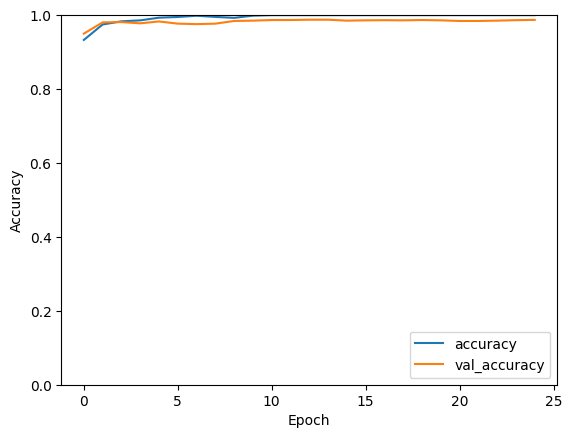

In [64]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_val, y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

As can be seen in the figure, the model got an accuracy of over 98.5% over the validation data, after just 25 epochs, even though there was a slight overfitting over the training data.

#### Steps 6 and 7: Analyzing the performance over test data:

Let's first calculate some of the most used metrics, so we can better understand the pros and cons of the model.

In [87]:
from sklearn.metrics import classification_report

y_pred_labels = np.argmax(model.predict(x_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)

report = classification_report(y_true_labels, y_pred_labels,
                      target_names=list(CLASS.keys()))
print(report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

        Cars       0.97      0.98      0.97       574
      Drones       0.97      0.98      0.97       512
      People       1.00      0.99      0.99       647

    accuracy                           0.98      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.98      0.98      0.98      1733



As it can be seem from the above report, the model has excellent performance across all classes, with a note for people recognition, which has almost perfect scores. Nonetheless, the metrics say the proposed model can be a good choice for a precise/fast system.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
55/55 - 0s - 5ms/step - accuracy: 0.9821 - loss: 0.0656


[0.06559498608112335, 0.982111930847168]

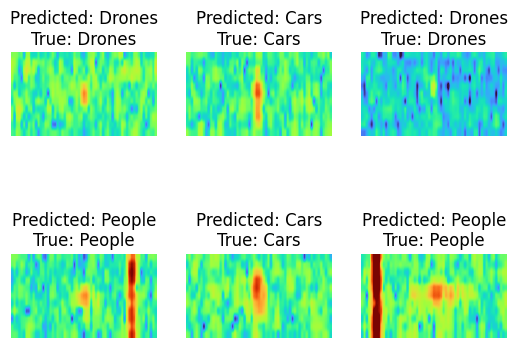

In [90]:
# testing the model on some of the samples

indices = np.random.choice(len(x_test), 6)
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[idx, :, :, 1], cmap='turbo', vmin=-140, vmax=-70, aspect=3.2)
    plt.title('Predicted: ' + list(CLASS.keys())[np.argmax(model.predict(x_test[idx:idx+1]))] 
              + '\nTrue: ' + list(CLASS.keys())[np.argmax(y_test[idx])])
    plt.axis('off')

model.evaluate(x_test, y_test, verbose=2)

#### Step 8: Comparing the model to the proposed in the reference paper

In [91]:
# defining the proposed model:
proposed_model = keras.models.Sequential()

normalizer = keras.layers.Normalization(input_shape=(11, 61, 3))
normalizer.adapt(x)

proposed_model.add(normalizer)
proposed_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
proposed_model.add(keras.layers.Flatten())
proposed_model.add(keras.layers.Dense(64, activation='relu'))
proposed_model.add(keras.layers.Dense(64, activation='relu'))
proposed_model.add(keras.layers.Dense(64, activation='relu'))
proposed_model.add(keras.layers.Dense(3, activation='softmax'))

proposed_model.summary()


/home/grey/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 11, 61, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 59, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,087,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,096,970 (4.18 MB)

 Trainable params: 1,096,963 (4.18 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8782 - loss: 0.3009 - val_accuracy: 0.9701 - val_loss: 0.0917
Epoch 2/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9809 - loss: 0.0558 - val_accuracy: 0.9654 - val_loss: 0.0902
Epoch 3/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9865 - loss: 0.0461 - val_accuracy: 0.9581 - val_loss: 0.1270
Epoch 4/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9776 - loss: 0.0793 - val_accuracy: 0.9756 - val_loss: 0.0839
Epoch 5/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9986 - loss: 0.0031 - val_accuracy: 0.9791 - val_loss: 0.0618
Epoch 6/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9958 - loss: 0.0138 - val_accuracy: 0.9820 - val_loss: 0.0579
Epoch 7/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9572 - val_loss: 0.2047
Epoch 8/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9867 - loss: 0.0477 - val_accu

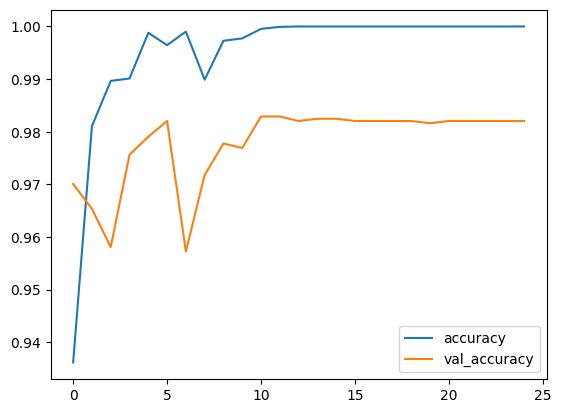

In [92]:
# compiling the model with the same optimizer and hyperparameters
proposed_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# trainining the model with the same datasets
history = proposed_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_val, y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

After training it, let's analyze the class-wise performance metrics.

In [94]:
y_pred_labels = np.argmax(proposed_model.predict(x_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)

report = classification_report(y_true_labels, y_pred_labels,
                      target_names=list(CLASS.keys()))
print(report)

proposed_model.evaluate(x_test, y_test, verbose=2)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

        Cars       0.98      0.97      0.98       574
      Drones       0.97      0.98      0.98       512
      People       1.00      0.99      0.99       647

    accuracy                           0.98      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.98      0.98      0.98      1733

55/55 - 0s - 2ms/step - accuracy: 0.9827 - loss: 0.1170


[0.11703064292669296, 0.9826889634132385]

As it's seem, our model proposed here achieves almost the same performance as the one proposed in the reference paper, when using the same parameters like learning rate and number of epochs. 

That similar result may be because the proposed model still has the same convolution and time-stability analysis, which are the crucial parts of the task.

The downside of the proposed one is that it takes more time to train, even though the prediction is faster, making the difference when dealing with time-critical applications like real-time object tracking.

#### Step 9: Comparing performance with classic models

At last, we'll be comparing the performance of the two models to one of the many classic CNN models that can be used to solve this same problem. With the goal of adapting to the proposed drone radar system, the MobileNetV3-Small model was chosen, as it is a lightweight model under the MobileNet series, which is already widely used on real-time applications.

In [108]:
# loading the model:
base_model = keras.applications.MobileNetV3Small(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

# Freeze the base model (had better performance training'em)
# base_model.trainable = False

# Add new classification layers on top of the base model
z = base_model.output
z = keras.layers.GlobalAveragePooling2D()(z)
z = keras.layers.Dense(1024, activation='relu')(z)
predictions = keras.layers.Dense(3, activation='softmax')(z)  # Assuming 3 classes

# Create the full model
mobile_net = keras.models.Model(inputs=base_model.input, outputs=predictions)

# compiling the model
mobile_net.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# preprocessing the data
def resize_images(images, target_size=(32, 32)):
    resized_images = np.array([tf.image.resize(image, target_size) for image in images])
    print(resized_images.shape)
    return resized_images

x_train_resized = resize_images(x_train, target_size=(32, 32))
x_val_resized = resize_images(x_val, target_size=(32, 32))
x_test_resized = resize_images(x_test, target_size=(32, 32))

# training the model
history = mobile_net.fit(x_train_resized, y_train, epochs=25, batch_size=32, validation_data=(x_val_resized, y_val))

/home/grey/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


(13253, 32, 32, 3)
(2339, 32, 32, 3)
(1733, 32, 32, 3)
Epoch 1/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.7288 - loss: 0.7576 - val_accuracy: 0.3942 - val_loss: 1.3573
Epoch 2/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8923 - loss: 0.2605 - val_accuracy: 0.4656 - val_loss: 1.1748
Epoch 3/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9246 - loss: 0.1856 - val_accuracy: 0.5990 - val_loss: 0.9675
Epoch 4/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9409 - loss: 0.1510 - val_accuracy: 0.6127 - val_loss: 0.7331
Epoch 5/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9570 - loss: 0.1179 - val_accuracy: 0.7606 - val_loss: 0.6222
Epoch 6/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9633 - loss: 0.0945 - val_accuracy: 0.8662 - val_loss: 0.3863
Epoch 7/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9708 - loss: 0.0833 - val_accuracy: 0.8354 - val_loss: 0.4604
Epoch 8/25
415/415 ━━━━━━━━━━━━━━━━━━━━ 9

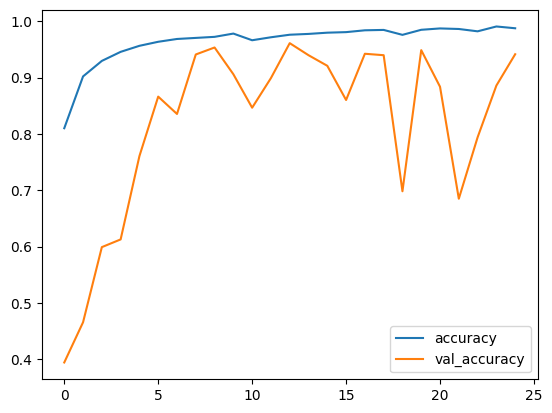

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

        Cars       0.92      0.90      0.91       574
      Drones       0.90      0.90      0.90       512
      People       0.98      0.99      0.99       647

    accuracy                           0.94      1733
   macro avg       0.93      0.93      0.93      1733
weighted avg       0.94      0.94      0.94      1733

55/55 - 0s - 2ms/step - accuracy: 0.9827 - loss: 0.1170


[0.11703064292669296, 0.9826889634132385]

In [110]:
# plotting the training data 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# displaying the performance metrics
y_pred_labels = np.argmax(mobile_net.predict(x_test_resized), axis=1)
y_true_labels = np.argmax(y_test, axis=1)

report = classification_report(y_true_labels, y_pred_labels,
                      target_names=list(CLASS.keys()))
print(report)

proposed_model.evaluate(x_test, y_test, verbose=2)

It can be seem from the pre-trained model history graph that it had some degree of overfitting over the training data, but still achieved a good accuracy over the test subset, with a slight decrease in performance when compared to the proposed and reference models.

One interesting fact is that the People class had almost the same performance as the proposed model, with over 98% precision. Nonetheless, the other classes had a slight decrease in performance, which may have happened due to the pre-training of the filters on the convolutional layers, which may not be the best ones for the task.

Aside from the performance drop, other drawbacks regarding the use of this model include the need of resizing and preproccessing, which is not recommended for real-time object tracking tasks, as well as the need of more time to train, as it has much more layers than the proposed model.

It is, nevertheless, noticeable that such a general-use model can achieve satisfactory performance without extensive hyperparameter tuning.